# Lab 12: Image denoising

### Due December 4th, 2021 11:59 PM CST

#### Logistics and Lab Submission

See the [course website](https://courses.engr.illinois.edu/ece365/fa2019/logisticsvvv.html).

This lab covers denoising and diffusion maps:

- PCA for dimensionality reduction and denoising
- Wiener filtering
- Diffusion maps

The submission procedure is provided below:
- You will be provided with a template Python script (main.py) for this lab where you need to implement the provided functions as needed for each question. Follow the instructions provided in this Jupyter Notebook (.ipynb) to implement the required functions. **Do not change the file name or the function headers!**
- <b>This lab contains non-programming questions.</b> These questions will be graded manually and their score will appear after the submission deadline. You can write your solutions on paper, scan (or take a photo) of your solutions and upload them as a pdf file under the name `Lab12.pdf`.
- Upload <b>BOTH</b> your Python script (.py file) and the pdf file containing your solutions (Lab12.pdf) on Gradescope.
- Your grades and feedbacks will appear on Gradescope. The grading for the programming questions is automated using Gradescope autograder, no partial credits are given. Therefore, if you wish, you will have a chance to re-submit your code **within 72 hours** of receiving your first grade for this lab, only if you have *reasonable* submissions before the deadline (i.e. not an empty script).
- If you re-submit, the final grade for the programming part of this lab will be calculated as .4 \* first_grade + .6 \* .9 \* re-submission_grade.

The purpose of problems titled `Visualization` are to better understand and test your results visually. `Visualization` problems will <b>NOT</b> be graded.

## Please type all your answers to programming problems in *main.py*. 
## You can write your solutions for non-programming problems on paper, scan (or take a photo of) your solutions and upload them as a pdf file under the name Lab12.pdf. You need to submit both *main.py* and *Lab12.pdf*.

#### Preamble (Don't change this)

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy.io

Populating the interactive namespace from numpy and matplotlib


This line runs your python script that you are going to submit. Objects are created for your reference. You can copy-paste this box so you don't need to come up later. **Do not change the file name!**

In [2]:
%run main.py
q1 = Question1()
q2 = Question2()
q3 = Question3()

## Problem 1 : Principal Component Analysis, PCA (20 points)

Given a dataset, PCA finds the principal axes of the dataset, those that well describe it. PCA specifies the axes along which the data has the highest variance. To understand PCA, let's look at the following example. This example is taken from Python Data Science Handbook by Jake VanderPlas.

We are given a dataset consisting of $200$ points distributed in 2D space. Below we define and plot this dataset:

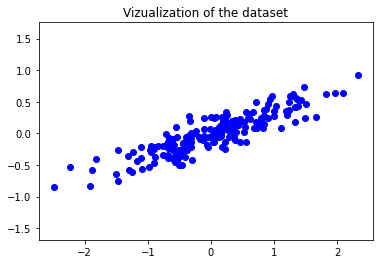

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

plt.figure()
plt.scatter(X[:, 0], X[:, 1], color='blue')
plt.title('Vizualization of the dataset')
plt.axis('equal');

We observe a relationship between the $x$ and $y$ coordinates of the points in the dataset (it seems like there is a linear relationship between the $x$ and $y$ coordinates of the samples of this dataset). Given the above dataset let's see the principal axes specified by PCA. For this purpose, we use `sklearn` library.

In [4]:
pca = PCA(n_components=2)
pca.fit(X)

princ_axes = pca.components_
princ_std = np.sqrt(pca.explained_variance_) * 3.

Now let's visualize the principal axes alongside the data.

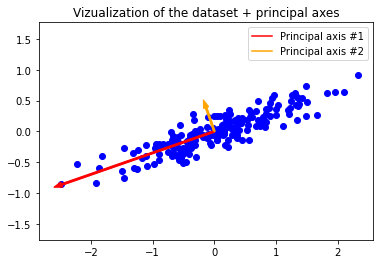

In [5]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], color='blue')

plt.plot(np.array([0, princ_axes[0, 0] * princ_std[0]]), 
         np.array([0, princ_axes[1, 0] * princ_std[0]]), 
         color='red',
         label='Principal axis #1')

plt.arrow(x=0, y=0, 
          dx=princ_axes[0, 0] * princ_std[0], dy=princ_axes[1, 0] * princ_std[0], 
          width=.03, 
          color='red')

plt.plot(np.array([0, princ_axes[0, 1] * princ_std[1]]), 
         np.array([0, princ_axes[1, 1] * princ_std[1]]), 
         color='orange', 
         label='Principal axis #2')

plt.arrow(x=0, y=0, 
          dx=princ_axes[0, 1] * princ_std[1], dy=princ_axes[1, 1] * princ_std[1], 
          width=.03, 
          color='orange')

plt.title('Vizualization of the dataset + principal axes')
plt.legend()
plt.axis('equal');

The above visualization shows the principal axes. The length of the axes is related to the variance of the dataset along that axis. Therefore, the dataset has a larger variance along the first principal axis (in red) compared to the second principal axis (in orange). 

This means we can choose to represent the dataset based on the first principal axis. In other words, we can project the dataset on the first principal axis and discard the remaining part of the data projected on the second principal axis. Let's check this visually.

In [6]:
# project the dataset onto the first principal axis
pca = PCA(n_components = 1).fit(X)
components = pca.transform(X)
filtered = pca.inverse_transform(components)

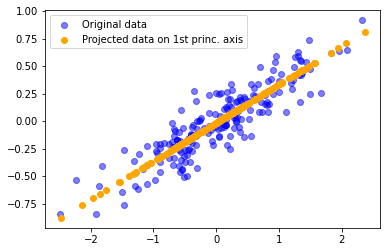

In [7]:
plt.figure()
plt.scatter(X[0, 0], X[0, 1], alpha=0.5, color='blue', label='Original data')
plt.scatter(filtered[0, 0], filtered[0, 1], color='orange', label='Projected data on 1st princ. axis')
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color='blue')
plt.scatter(filtered[:, 0], filtered[:, 1], color='orange')
plt.legend()
plt.show()

Note that after the projection on the first principal axis, the projected data points lie on the first principal axis.

### Problem 1-1: PCA for dimensionality reduction (10 points)

One application of PCA is reducing the dimentionality of a high-dimensional dataset. This is helpful when we want to visualize a high dimensional dataset and its underlying structure. Let's assume we have a dataset ${X}\in \mathbb{R}^{L \times n}$. This dataset contains $n$ samples. Each of the samples are a vector of length $L$, where $L$ can be larger than $3$. For $L>3$ we cannot visualize this dataset in its original form. Thus, using PCA, we aim to reduce its dimensionality (by projecting the dataset onto a subset of the prinicipal axis).

Here we list the PCA steps and how we can represent the dataset on a smaller subspace constructed by $K$ of the principal axes.
* Construct the mean of the samples. Let's call this mean $\overline{X}$. $\overline{X}$ is a vector of length $L$.
* Construct the covarinace matrix as:
\begin{align}
C = \frac{1}{n} (X-\overline{X}) (X-\overline{X})^T 
\tag 1
\end{align}
* Perform eigenvalue decomposition on $C$. This would give you a set of eigenvectors and eigenvalues of $C$.
* Choose $K$ top eigenvectors, i.e. the eigenvectors associated with the $K$ largest eigenvalues. These vectores will be your $K$ prinicipal axes. Lets denote these $K$ vectors as $\{u_k\}_{k=1}^K$
* Find the components of the data samples along the principal axes. For any data sample $x \in X$ (i.e. $x$ is a column in $X$), this is obtained by:
\begin{align}
\widehat{c} = [<x, u_1>, <x, u_2>, ..., <x, u_K>]
\tag 2
\end{align}
where $<., .>$ represents inner product and $\widehat{c}$ contains the components of $x$ along the top $K$ eigenvectors of $C$.
***

Based on the above descriptions, in this problem, we aim to use PCA to reduce the dimension of a dataset and visualize its structure after dimensionality reduction.

Write a function that reduces the dimensionality of a dataset ${X}$ using $K=2$ number of principal axes. Follow the steps described above.

Inputs:
* The dataset ${X} \in \mathbb{R}^{L \times n}$, a np.ndarray of shape $L \times n$ where $L$ is the dimension of the data samples (i.e. each data sample is a vector of length $L$) and $n$ is the number of samples.

Outputs:
* A np.ndarray of shape $2 \times n$. The output corresponds to the components of the data samples along the first two principal axes.

Add your code to `Question1.pca_reduce_dimen` in `main.py`. You are <b>NOT</b> allowed to use `sklearn` library and are asked to implement PCA from scratch. You can compare your implementation with the results from `sklearn` functions.

### Visualization: Testing your Problem 1-1 solution on a dataset with $L=10$

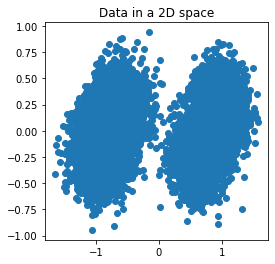

In [8]:
# load the data
X = scipy.io.loadmat('problem1_1.mat')['X']

comps = q1.pca_reduce_dimen(X)

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.scatter(comps[0, :], comps[1, :])
axes.set_title("Data in a 2D space")
plt.show()

# Do you see any structure in the dataset?

### Problem 1-2: PCA for denoising (10 points)
Another application of PCA is denoising. Looking back at the example provided at the begining of Problem 1, after projecting the data on the first prinicipal axis we sort of denoised the dataset!

In this problem, our goal is to project a dataset containing noisy samples on a subset of the principal axes. This helps in denoising the dataset. To obtain the projection of the dataset on the top $K$ principal axes , you need to follow the same steps as discussed in Problem 1-1, except the last step. You need to replace the last step with:
* 
\begin{align}
\widehat{x} = \sum\limits_{k=1}^K <x, u_k> u_k
\tag 3
\end{align}
where $x \in X$ and $\widehat{x}$ denotes $x$ projected onto the $K$ principal axes.
***
Write a function that denoises a noisy dataset by projecting the dataset onto the $K$ principal axes. 

The inputs:
* The dataset $X$, a np.ndarray matrix of size $L \times n$. Here, $L$ denotes the dimentionality of the samples and $n$ is the number of samples.
* $K$, a scalar denoting the number of principal axes.

The outputs:
* A np.ndarray matrix of size $L \times n$ containing the denoised samples.

Add your code to `Question1.pca_project` in `main.py`. You are <b>NOT</b> allowed to use `sklearn` library and are asked to implement PCA from scratch. You can compare your implementation with the results from `sklearn` functions.

### Visualiziation: Denoising example #1
Let's check your implementation on a dataset with $L=15$. Below, we first generate this dataset.

In [9]:
# Generating a dataset
num_samples = 10000 # number of samples in the dataset
num_dim = 15
mu1 = np.ones((1, num_dim))
mu2 = np.ones((1, num_dim))*-1

X1 = mu1 + np.random.normal(size=(num_samples//2, num_dim)) * 0.7
X2 = mu2 + np.random.normal(size=(num_samples//2, num_dim)) * 0.7
X1_clean = mu1 + np.random.normal(size=(num_samples//2, num_dim)) * 0.
X2_clean = mu2 + np.random.normal(size=(num_samples//2, num_dim)) * 0.
X = np.concatenate((X1, X2), axis=0).T
X_clean = np.concatenate((X1_clean, X2_clean), axis=0).T

In [10]:
denoised = q1.pca_project(X, 2)

TypeError: 'NoneType' object is not subscriptable

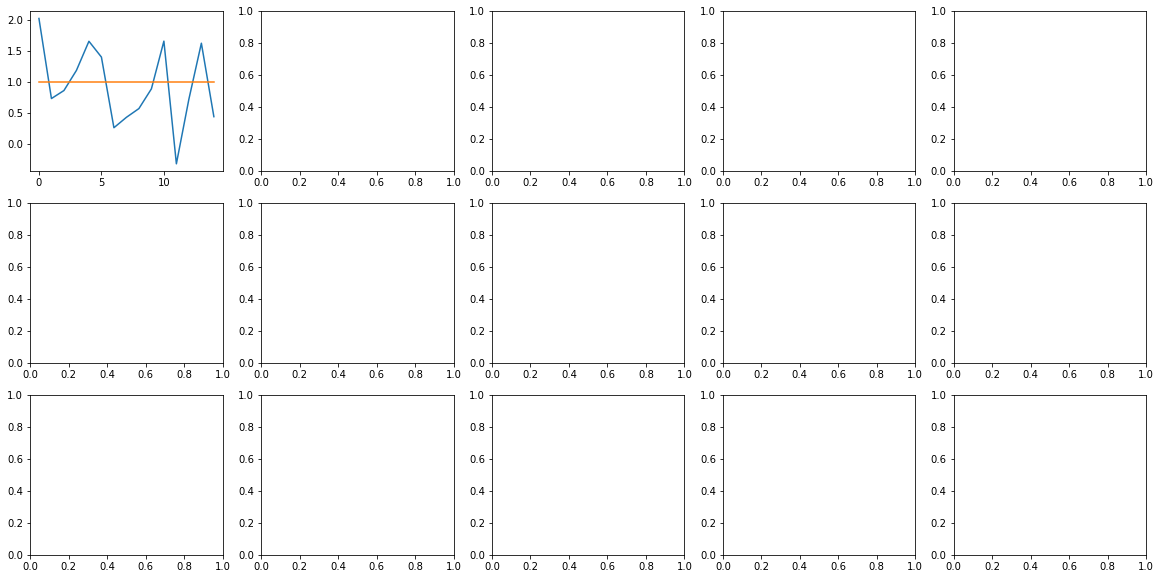

In [11]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
count = 0
for row in range(3):
    for col in range(5):
        ind = count * 100
        axes[row, col].plot(X[:, ind], label='Noisy sample')
        axes[row, col].plot(X_clean[:, ind], label='Clean sample')
        axes[row, col].plot(denoised[:, ind], label='PCA denoised')
        axes[row, col].set_title('Data sample #{0}'.format(count))
        if row==0 and col==0:
            axes[row, col].legend()
        count +=1 
plt.show()

After denoising the samples, the denoised samples are closer to the clean samples.

### Visualiziation: Denoising example #2
In this example, we are denoising a set of noisy cryo-EM projection images using our implementation in Problem 1-2. Note that in this example, the projection images are of size $41 \times 41$. But, we vectorize them before performing PCA. This means for this example the dimensionality of the data samples is $L = 41^2 = 1681$.

In [12]:
# load data
mat = scipy.io.loadmat('problem1_2.mat')
projs_noisy = mat['projs_noisy']
projs_clean = mat['projs_clean']
n = int(np.sqrt(projs_noisy.shape[0]))

In [13]:
# denoising noisy projection images using PCA
# Feel free to change K and see how the denosing results change!
K = 10
denoised = q1.pca_project(projs_noisy.T, K)

TypeError: 'NoneType' object is not subscriptable

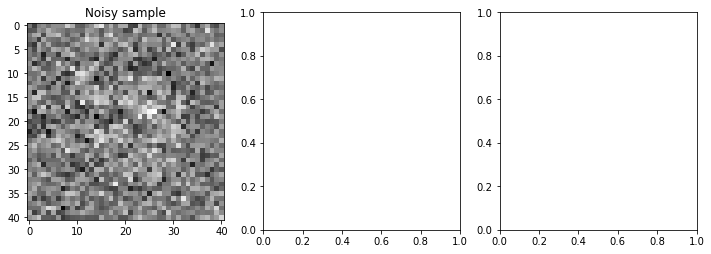

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ind = 0
axes[0].imshow(np.reshape(projs_noisy.T[ind, :], [n, n]), cmap='gray')
axes[0].set_title('Noisy sample')
axes[1].imshow(np.reshape(denoised[ind, :], [n, n]), cmap='gray')
axes[1].set_title('PCA denoised')
axes[2].imshow(np.reshape(projs_clean.T[ind, :], [n, n]), cmap='gray')
axes[2].set_title('Clean sample')
plt.show()

## Problem 2: Wiener filtering (20 points)
Please refer to the lecture notes to review Wiener filter.

### Problem 2-1: Wiener filter expression (10 points)
Derive the linear minimum mean squared error estimator of $x$ given the measurements $y = x + \varepsilon$, where $y, x, \varepsilon \in \mathbb{R}^L$, $\mathbb{E}[x] = \mu$ and the covariance of $x$ is $\Sigma$. The additive noise $\varepsilon$ is a random Gaussian vector with mean $0_L$ (a vector of zeros of length $L$) and covariance $\sigma^2 I_{L \times L}$ ($I_{L \times L}$ is the identity matrix of size ${L \times L}$).

Add your solution to `Lab12.pdf`. You can write your answer on a paper, take a snapshot of your solution and add it to `Lab12.pdf`. Please mark your solution for this problem with `Problem 2-1`.

### Problem 2-2: Wiener filter for image denoising (10 points)
Write a function that implements the Wiener filter derived in Problem 2-1. For this problem, assume that $\mu$, $\Sigma$ and $\sigma$ are given.

Inputs:
* A noisy dataset, a np.ndarray of shape $L \times n$.
* $\Sigma$, The covariance matrix of $x$, a np.ndarray of shape $L \times L$.
* $\mu$, the mean of $x$, a np.ndarray of length $L$.
* $\sigma$ the noise standard deviation on each pixel

Outputs:
* Wiener filtered samples, a np.ndarray of shape $L \times n$.

Add your code to `Question2.wiener_filter` in `main.py`. You are <b>NOT</b> allowed to use pre-defined functions in Python.

### Visualization: Image denoising
Let's check the performance of the Wiener filter on a cryo-EM projection image denoising task. For this purpose, you are given the mean vector $\mathbb{E}[x] = \mu$, the covariance matrix of the clean data $\Sigma$ and $\sigma$. Let's first load the dataset.

In [15]:
# load the data
mat = scipy.io.loadmat('problem2_2.mat')
mu = mat['mu']
C = mat['C']
sigma = mat['sigma']
projs_noisy = mat['projs_noisy']
projs_clean = mat['projs_clean']

Now we denoise the noisy projection images using the Wiener filter. We visualize the noisy, filtered and clean samples below. 

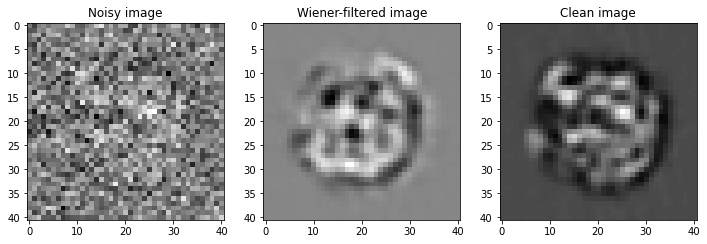

In [16]:
filtered_imgs = q2.wiener_filter(projs_noisy, C, mu, sigma)
ind = 0
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(np.reshape(projs_noisy[:, ind], [n, n]), cmap='gray')
axes[0].set_title('Noisy image')
axes[1].imshow(np.reshape(filtered_imgs[:, ind], [n, n]), cmap='gray')
axes[1].set_title('Wiener-filtered image')
axes[2].imshow(np.reshape(projs_clean[:, ind], [n, n]), cmap='gray')
axes[2].set_title('Clean image')
plt.show()

Optional (no points): If you are not given $\sigma$ and $\mu$, can you estimate it from the noisy dataset?

## Problem 3: Diffusion maps (30 points)
Diffusion maps, similar to PCA, are used for dimensionality reduction and data analysis. In this problem, we assume we are given the Markov transition matrix $A$ and we practice some concepts discussed in the lecture.

### Problem 3-1: Derivation of Eigenvectors and values of a ring graph (10 points)
Assume a ring graph with $n$ vertices. The transition matrix of this graph is of size $n \times n$ and has the following form:
\begin{align}
A = 
\begin{bmatrix}
0& \frac{1}{2}& 0& \ldots & 0 & \frac{1}{2} \\
\frac{1}{2}& 0& \frac{1}{2}& 0 & \ldots & 0 \\
0 & \frac{1}{2}& 0& \frac{1}{2}& \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & 0 & 0 \\
0 & \ldots & 0 & \frac{1}{2} & 0 & \frac{1}{2} \\
\frac{1}{2} & 0 & \ldots & 0 & \frac{1}{2} & 0
\end{bmatrix}
\end{align}

Show that the vectors $\{v_\ell\}_{\ell=1}^n$ given by:
\begin{align}
v_\ell(r) = e^{2 \pi i r \ell/n}
\end{align}
are the eigenvectors of $A$. Also, derive the eigenvalues of $A$.

Add your solution to `Lab12.pdf`. You can write your answer on a paper, take a snapshot of your solution and add it to `Lab12.pdf`. Please mark your solution for this problem with `Problem 3-1`.

### Problem 3-2: Derivation of Eigenvectors and values of a complete graph (10 points)
Assume a complete graph with $n$ vertices. The transition matrix of this graph is of size $n \times n$ and has the following form:
\begin{align}
A = 
\begin{bmatrix}
0& \frac{1}{n-1}& \frac{1}{n-1}& \ldots & \frac{1}{n-1} & \frac{1}{n-1} \\
\frac{1}{n-1}& 0& \frac{1}{n-1}& \frac{1}{n-1} & \ldots & \frac{1}{n-1} \\
\frac{1}{n-1} & \frac{1}{n-1}& 0& \frac{1}{n-1}& \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \frac{1}{n-1} & \frac{1}{n-1} \\
\frac{1}{n-1} & \ldots & \frac{1}{n-1} & \frac{1}{n-1} & 0 & \frac{1}{n-1} \\
\frac{1}{n-1} & \frac{1}{n-1} & \ldots & \frac{1}{n-1} & \frac{1}{n-1} & 0
\end{bmatrix}
\end{align}

Derive the eigenvalues of the matrix $A$ for a complete graph.

Add your solution to `Lab12.pdf`. You can write your answer on a paper, take a snapshot of your solution and add it to `Lab12.pdf`. Please mark your solution for this problem with `Problem 3-2`.

### Problem 3-3: Eigenvectors and eigenvalues of a graph (10 points)
Write a function that given $A$, outputs the top-$(n-1)$ non-trivial eigenvectors and all eigen-values of $A$ in descending order. Note that, these eigenvectors constitute the embedding of this graph.

Inputs: 
* $A$ a $n \times n$ np.ndarray denoting the Markov transition matrix of the graph.

Outputs:
* Sorted eigenvalues of $A$ in decsending order, a np.ndarray of length $n$.
* Top $n-1$ non-trivial eigenvectors, a np.ndarray of shape $n \times n-1$.

Add your code to `Question3.embedding` in `main.py`. You can check if the results of this function match your derivations in Problem 3-1 and 3-2.

### Visualization: Embedding of a ring graph
Test your code on ring and complete graphs and check if the results matches with your derivations in problem 3-1 and 3-2.

In [ ]:
def construct_ring_graph(mat_sz):
    # ring graph
    row1 = np.zeros((mat_sz,))
    row1[1] = 0.5
    row1[-1] = 0.5
    W = scipy.linalg.circulant(row1)
    print(W)
    return W

In [ ]:
def construct_complete_graph(mat_sz):
    W = np.ones((mat_sz, mat_sz)) - np.eye(mat_sz)
    W /= (mat_sz-1)
    print(W)
    return W

In [ ]:
n = 12
W = construct_ring_graph(n)
v, w = q3.embedding(W)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(v[:, 0], v[:, 1])
plt.title('Embedding of ring graph')
ax.set_aspect('equal')
plt.show()

# eigen-value plots
plt.figure()
plt.plot(w, marker='x')
plt.ylabel('Eigen values')
plt.show()

### Visualization: Embedding of a complete graph

In [ ]:
# complete graph
n = 3
W = construct_complete_graph(n)
v, w = q3.embedding(W)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(v[:, 0], v[:, 1])
plt.title('Embedding of the complete graph')
ax.set_aspect('equal')
plt.show()

# eigen-value plots
plt.figure()
plt.plot(w, marker='x')
plt.ylabel('Eigen values')
plt.show()

## And this concludes Lab 12! Congratulations!